In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from CNN import CNN
import json
import time
import seaborn as sns

In [37]:
from keras.optimizers import Adam
import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [18]:
dataset_path = "./dataset"

class_names = os.listdir(dataset_path)
class_names = sorted(class_names)
class_names.remove('.DS_Store')
nb_classes = len(class_names)
print(f'The dataset contains {nb_classes} classes: {class_names}')

The dataset contains 4 classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [19]:
image_size = (128, 128)
batch_size = 32

X = []
y = []

for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale
        img = cv2.resize(img, image_size)  # Resize to 128x128 (image size of VGG16)
        img = img / 255.0  # Normalize pixel value to [0, 1]
        X.append(img)
        y.append(class_name)


In [20]:
# Convert to numpy arrays
X = np.array(X, dtype=np.float32).reshape(-1, image_size[0], image_size[1], 1)  # Reshape for CNN
y_label = np.array(y).reshape(-1, 1)


In [21]:
print(X.shape)
print(y_label.shape)

(5712, 128, 128, 1)
(5712, 1)


In [22]:
# Encode class labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y_label)  # Convert class names to binary

In [23]:
# Encode class labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y_label)  # Convert class names to binary

Shape of an image is (128, 128, 1)


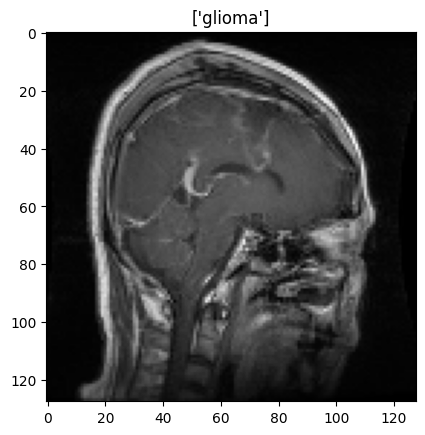

In [24]:
# Display a random image
rd = np.random.randint(0, len(X))
image = X[rd]
label = y_label[rd]
print(f'Shape of an image is {image.shape}')
plt.imshow(image, cmap='gray')
plt.title(label)
plt.show()

Glioma: 1321
Meningioma: 1339
No Tumor: 1595
Glioma: 1457


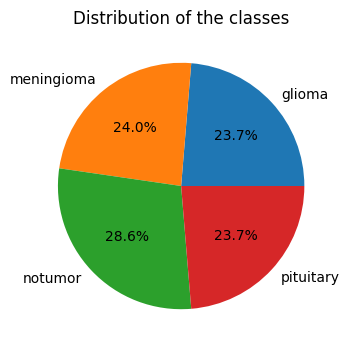

In [25]:
glioma_count = (y_label == 'glioma').sum()
meningioma_count = (y_label == 'meningioma').sum()
notumor_count = (y_label == 'notumor').sum()
pituitary_count = (y_label == 'pituitary').sum()

print(f"Glioma: {glioma_count}")
print(f"Meningioma: {meningioma_count}")
print(f"No Tumor: {notumor_count}")
print(f"Glioma: {pituitary_count}")

distribution = [glioma_count, meningioma_count, notumor_count, glioma_count]

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)

fig = plt.figure(figsize=(6, 4))
plt.pie(distribution, labels=class_names, autopct=lambda pct: func(pct, distribution))
plt.title("Distribution of the classes")
plt.savefig('./images/distribution.png')
plt.show()

In [26]:
# First split: Train (80%) and Temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# Second split: Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [27]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4569, 128, 128, 1)
X_val shape: (571, 128, 128, 1)
X_test shape: (572, 128, 128, 1)
y_train shape: (4569, 4)
y_val shape: (571, 4)
y_test shape: (572, 4)


In [28]:
# Quick tests to ensure the data is consistent and correctly split

assert len(X) == len(y), "X and y should be of same length" # If not, some images will be missing a label
assert len(X_train) == len(y_train), "X_train and y_train must be of same length"
assert len(X_val) == len(y_val), "X_val and y_val must be of same length"
assert len(X_test) == len(y_test), "X_test and y_test must be of same length"
assert len(X_train) + len(X_test) + len(X_val) == len(X), "X must be on length len(X_train) + len(X_test)"

In [29]:
optimizer = Adam(learning_rate=0.001)
CNN.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=['accuracy', 'precision', 'recall', 'f1_score', 'categorical_crossentropy', 'AUC'])

In [30]:
CNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 64, 64, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 32, 32, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 16, 16, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,514,948 (32.48 MB)

 Trainable params: 8,514,948 (32.48 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=5,          # Stop if no improvement for 5 consecutive epochs
    restore_best_weights=True  # Restore the best weights before stopping
)

checkpoint = ModelCheckpoint(
    "model_checkpoint.keras", monitor="val_loss",
    save_best_only=True, verbose=1
)

In [32]:
history = CNN.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    verbose=1,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - AUC: 0.8494 - accuracy: 0.6145 - categorical_crossentropy: 0.8825 - f1_score: 0.5982 - loss: 0.8825 - precision: 0.7353 - recall: 0.4486
Epoch 1: val_loss improved from inf to 0.45330, saving model to model_checkpoint.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 77s 252ms/step - AUC: 0.8496 - accuracy: 0.6149 - categorical_crossentropy: 0.8817 - f1_score: 0.5986 - loss: 0.8817 - precision: 0.7355 - recall: 0.4493 - val_AUC: 0.9638 - val_accuracy: 0.8354 - val_categorical_crossentropy: 0.4533 - val_f1_score: 0.8338 - val_loss: 0.4533 - val_precision: 0.8485 - val_recall: 0.8144
Epoch 2/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - AUC: 0.9753 - accuracy: 0.8658 - categorical_crossentropy: 0.3655 - f1_score: 0.8579 - loss: 0.3655 - precision: 0.8789 - recall: 0.8520
Epoch 2: val_loss improved from 0.45330 to 0.28868, saving model to model_checkpoint.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 73s 257ms/step - AUC: 0.9753 - accuracy: 0.8658 - categor

In [33]:
CNN.save('./Trained-Models/SimpleCNN.keras')

In [43]:
# Save the history
print(history.history)
with open('./Model-History/SimpleCNN.json', 'w') as f:
    json.dump(str(history.history), f)

{'AUC': [0.9277651309967041, 0.9764159321784973, 0.9885143041610718, 0.9944689869880676, 0.9976086616516113, 0.9982772469520569, 0.9983962774276733, 0.9984703063964844, 0.9993169903755188, 0.9999004006385803, 0.9994462728500366, 0.9996230006217957, 0.9988799095153809], 'accuracy': [0.7336397171020508, 0.8704311847686768, 0.9122346043586731, 0.9424381852149963, 0.9595097303390503, 0.9752681255340576, 0.9757058620452881, 0.9805209040641785, 0.987305760383606, 0.9949660897254944, 0.9912453293800354, 0.993652880191803, 0.9897133111953735], 'categorical_crossentropy': [0.648449182510376, 0.35408249497413635, 0.24040883779525757, 0.1632496565580368, 0.10144826769828796, 0.06951425969600677, 0.06930327415466309, 0.06482499092817307, 0.03860027715563774, 0.020728163421154022, 0.026183517649769783, 0.023869041353464127, 0.03829554095864296], 'f1_score': [<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.6926691 , 0.56808937, 0.81323695, 0.81806874], dtype=float32)>, <tf.Tensor: shape=(4,), 

In [44]:
# Evaluate the model
loss, accuracy, precision, recall, f1_score, categorical_crossentropy, AUC = CNN.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - AUC: 0.9960 - accuracy: 0.9544 - categorical_crossentropy: 0.1214 - f1_score: 0.9538 - loss: 0.1214 - precision: 0.9568 - recall: 0.9544


The model doesn't seem to be overfitting too much (accuracy on the training set is 0.99, while accuracy on the testing set is 0.95). This is a good result. Morover, the overall result are good, no matter the evaluation metric used. The model is able to predict the class of the images with a good accuracy.

We could try to improve the model by using a more complex model, like a CNN, or by using a more complex model. However, the current model is already good enough for the task, and its computation cost is low: the training time is very low (15min48s on my computer, which does not have a GPU). Therefore, I think that the current model is good enough for the task, and that we don't need to improve it further.

What would be interesting to do is to augment the dataset to improve the model. We could use data augmentation techniques (using GANs for instance) to generate new images based on the existing ones. This would allow the model to learn more features and to generalize better. It is not necessary but it can make us learn more.

In [45]:
# Save the evaluation metrics
metrics = {
    'loss': loss,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score,
    'categorical_crossentropy': categorical_crossentropy,
    'AUC': AUC
}

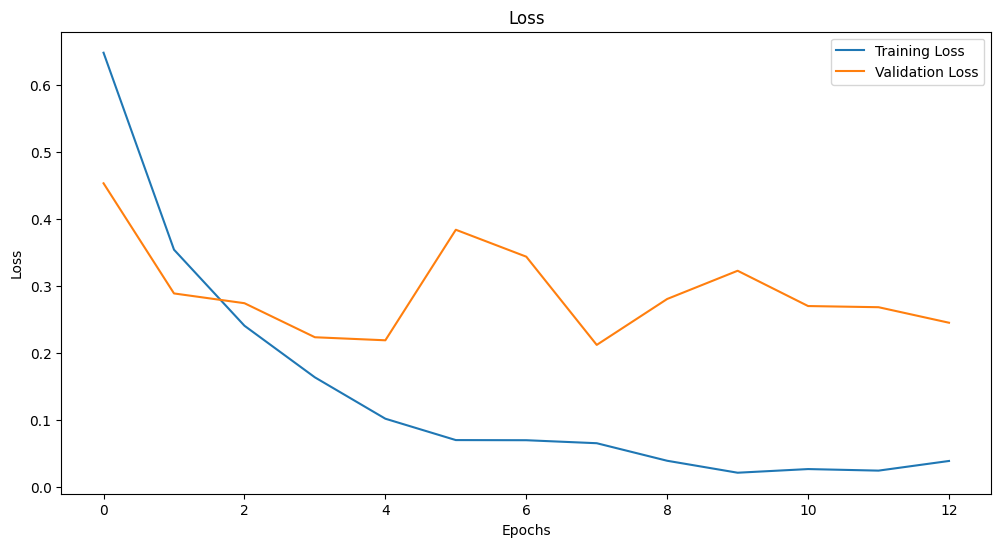

In [46]:
# Plot the training history
fig = plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./images/SimpleCNNLoss.png')
plt.show()


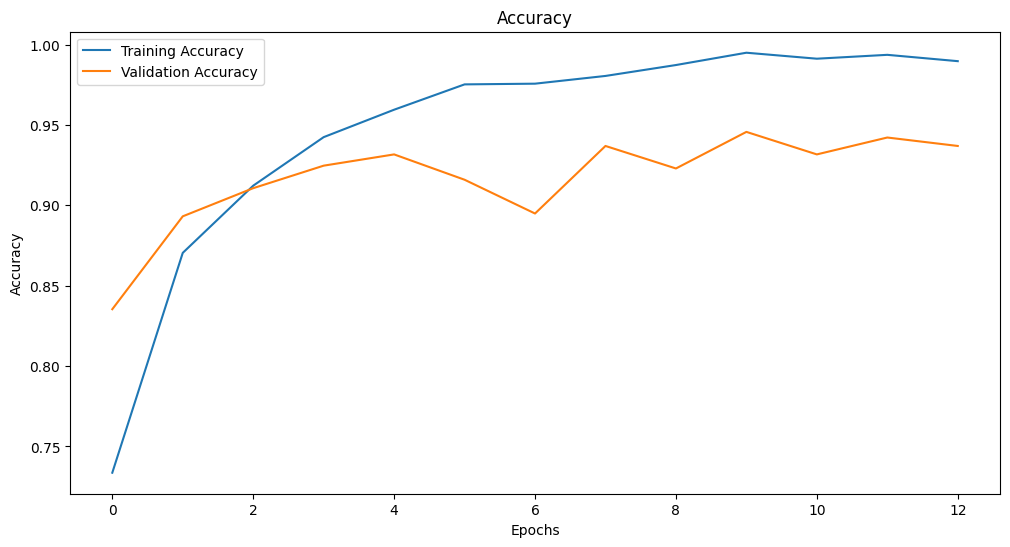

In [47]:
# Plot the accuracy history
fig = plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./images/SimpleCNNAccuracy.png')
plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step


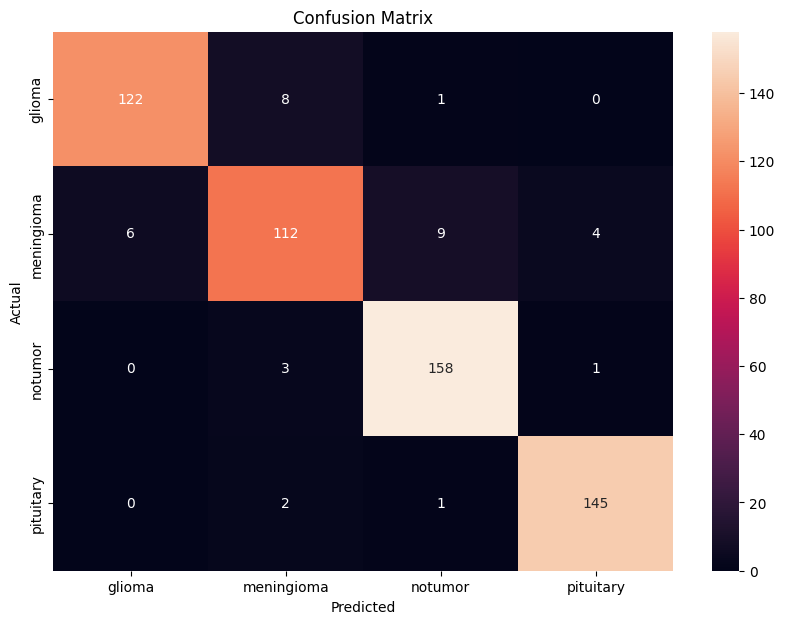

In [49]:
# Plot the confusion matrix
y_pred = CNN.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_matrix = sk.metrics.confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('./images/SimpleCNNConfusionMatrix.png')
plt.show()
